<a href="https://colab.research.google.com/github/tomdct/BlogColabScripts/blob/main/VisualisingSirens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Visualising sirens**

---

We produce some visualisations of both sirens and other types of neural network, and explore what happens when you tweak the parameters. My own blog page, written to accompany this code, can be found [here](https://sites.google.com/view/deeplearningblog/home/sirens/visualising-sirens).

The original siren project page can be found [here](https://www.vincentsitzmann.com/siren/), and our code has been partially adapted from their code, as well as my previous [post](https://sites.google.com/view/deeplearningblog/home/sirens/image-fitting-with-a-siren) and the accompanying [colab script](https://colab.research.google.com/drive/1q1yUc5fRElw-SZX5RVuTbeXZJ1fwIzCJ?usp=sharing).

(**N.B.** You are better off runing the code on this page with the GPU enabled, which you can find under `Runtime > Change runtime type > Hardware accelerator`, although the CPU does okay with small images and small amounts of training.)

# Preliminary business

We start by setting up all the packages and networks that we will be using. This section is very similar to the opening section of our [last notebook](https://colab.research.google.com/drive/1q1yUc5fRElw-SZX5RVuTbeXZJ1fwIzCJ?usp=sharing).

In [1]:
#@title We start by making all of the imports that we will need.

import os
import numpy as np
import matplotlib.pyplot as plt
import random
import requests
from PIL import Image, ImageDraw, ImageOps
from io import BytesIO
from collections import OrderedDict

import sys
import glob

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize, Compose, ToTensor, Normalize

In [2]:
#@title Creating a dataset from an image.

# We need to be able to create a dataset in order to feed the pixel color
# data into the training process for our neural networks. We do this in three
# steps:
#
#     1. Convert an image into a tensor.
#
#     2. Create a list of pixel coordinates.
#
#     3. Construct the dataset, which returns the
#        list of coordinates and corresponding pixel values.
#
# The dataset is designed to work with a batch size of 1. In other words,
# in each training loop the neural network sees all of the pixel data exactly
# once and tries to fit itself to it as well as possible.

def image_to_tensor(img):

    # Converts an image to a tensor where RGB values are rescaled
    # to lie in the interval [-1, 1].

    transform = Compose([
        ToTensor(),
        Normalize(torch.Tensor([0.5]),torch.Tensor([0.5]))
    ])

    return transform(img)


def create_grid(grid_steps, bounds=None):

    # Given the input
    #
    #    grid_steps = (a_1,a_2,...,a_n)
    #
    # this returns an list of coordinates for an n-dimensional grid
    # with a_i steps in the ith dimension.
    #
    # If bounds = None then the bounds in each dimension are [-1,1].

    grid_dim = len(grid_steps)

    if bounds == None:
        bounds = [ [-1,1] for i in range(grid_dim)]

    tensors = tuple( [ torch.linspace(bounds[i][0],
                                      bounds[i][1],
                                      steps=grid_steps[i]
                                      ) for i in range(grid_dim) ] )

    my_grid = torch.stack(torch.meshgrid(*tensors, indexing="ij"), dim=-1)
    return my_grid.reshape(-1, grid_dim)


class ImageFitter(Dataset):

    # This dataset is only designed to be called once, and returns all
    # coordinates and the corresponding pixel values.

    def __init__(self, img):
        super().__init__()
        img_tensor = image_to_tensor(img)
        self.pixels = img_tensor.permute(1, 2, 0).view(-1, no_of_channels)
        self.coords = create_grid((img.height, img.width))

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

In [3]:
#@title We define fully-connected feedforward (FCFF) networks.

# We define a siren as a special case of a FCFF network.

class CustomLayer(nn.Module):

    def __init__(self, func, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()

        self.func = func
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return self.func(self.omega_0 * self.linear(input))


class FCFFNetwork(nn.Module):

    def __init__(self, func, layer_sizes, outermost_linear=True, omega_0=30, first_bias=True, hidden_bias=True, last_bias=True):
        super().__init__()

        self.func = func
        self.layer_sizes = layer_sizes
        self.no_of_layers = len(layer_sizes)
        self.net = []

        if len(layer_sizes) > 2:

            # First layer
            self.net.append(CustomLayer(func, layer_sizes[0], layer_sizes[1], is_first=True, omega_0=omega_0, bias=first_bias))

            # Hidden layers
            for i in range(1, self.no_of_layers - 2):
                self.net.append(CustomLayer(func, layer_sizes[i], layer_sizes[i+1],
                                              is_first=False, omega_0=omega_0, bias=hidden_bias))

        # Last layer
        if outermost_linear:
            final_linear = nn.Linear( layer_sizes[self.no_of_layers-2], layer_sizes[self.no_of_layers-1], bias=last_bias )

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / layer_sizes[self.no_of_layers-1]) / omega_0,
                                              np.sqrt(6 / layer_sizes[self.no_of_layers-1]) / omega_0)

            self.net.append(final_linear)

        else:
            self.net.append(CustomLayer(func, layer_sizes[self.no_of_layers-2], layer_sizes[self.no_of_layers-1],
                                          is_first=False, omega_0=omega_0, bias=last_bias))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        output = self.net(coords)
        return output, coords

In [4]:
#@title Implement a training loop for a given neural network.

# First we have a function for converting tensors back to images.

def tensor_to_image(t, img_height, img_width, no_of_channels):

    # Converts a tensor with values in [-1, 1] back into
    # a numpy array with values in [0, 1] that represents
    # an image.
    #
    # Note: After converting we clip to the range [0, 1],
    #       since some float values can end up being 1.000001
    #       (or -0.000001, or similar).

    t = (t + 1)/2
    t = torch.max( torch.zeros_like(t), torch.min( torch.ones_like(t), t ) )

    return t.cpu().view(img_height, img_width, no_of_channels).detach().numpy()


# Now we define a summary step for our training loop.

def print_summary(step, loss, model_output, original_img):

    fig, ax = plt.subplots(1,2)

    ax[0].imshow( tensor_to_image(model_output, img_height, img_width, no_of_channels) )
    ax[0].set_title(f"After %d steps, loss=%0.6f." % (step, loss))
    ax[0].axis('off')

    ax[1].imshow( tensor_to_image(original_img, img_height, img_width, no_of_channels) )
    ax[1].set_title(f"Original image")
    ax[1].axis('off')

    plt.show()


# Now implement the training loop for a given model, optimiser and dataloader.

def run_training_loop(model, optim, dataloader, total_steps, steps_til_summary):

    model_input, original_img = next(iter(dataloader))

    if torch.cuda.is_available():
        model_input, original_img = model_input.cuda(), original_img.cuda()

    for step in range(total_steps+1):
        model_output, coords = model(model_input)
        loss = ((model_output - original_img)**2).mean()

        optim.zero_grad()
        loss.backward()
        optim.step()

        if not step % steps_til_summary:
            print_summary(step, loss, model_output, original_img)

# We also write a comparison version of the training loop, for training
# three models at once.

# Comparison summary for the training loop.

def print_comparison_summary(step, model_names, model_output):

    fig, ax = plt.subplots(1, len(model_names))

    for i in range(len(model_names)):
        ax[i].axis('off')
        ax[i].imshow( tensor_to_image(model_output[i], img_height, img_width, no_of_channels) )
        ax[i].set_title(model_names[i])

    plt.show()

# Now implement the training loop for a given model, optimiser and dataloader.

def run_comparison_training_loop(models, optims, dataloader, total_steps, steps_til_summary):

    model_names = [ m.func.__name__ for m in models ]

    model_input, original_img = next(iter(dataloader))

    if torch.cuda.is_available():
        model_input, original_img = model_input.cuda(), original_img.cuda()

    for step in range(total_steps+1):
        model_outputs = []
        losses = []

        for i in range(len(models)):
            model = models[i]
            optim = optims[i]

            model_output, coords = model(model_input)
            model_outputs.append(model_output)

            loss = ((model_output - original_img)**2).mean()
            losses.append(loss)

            optim.zero_grad()
            loss.backward()
            optim.step()

        if not step % steps_til_summary:
            print(f'After %d steps:' % step)

            for i in range(len(models)):
                print(f'%s loss = %0.6f' % (model_names[i], losses[i]))

            print_comparison_summary(step, model_names, model_outputs)

# Training the networks

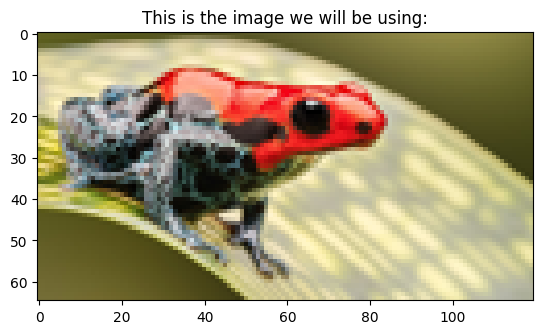

In [5]:
#@title First we load our image.

# Loading the image from a url.

img_url = 'https://savethefrogs.com/wp-content/uploads/Poison-Dart-Frog-1-1920px.jpeg'
response = requests.get(img_url)
my_img = Image.open(BytesIO(response.content))

# We reduce everything down by a scale factor of 16, to
# speed up the experiments. To use the original image
# set scale_factor = 1

scale_factor = 16
my_img = my_img.resize([my_img.width // scale_factor, my_img.height // scale_factor])

# Collect height, width and the number of channels

img_width, img_height = my_img.size[0], my_img.size[1]
img_size = (img_height, img_width)
no_of_channels = len(my_img.getbands())

# We create a dataloader that will supply the data from our image.

my_image_fitter = ImageFitter(my_img)
my_dataloader = DataLoader(my_image_fitter, batch_size=1, pin_memory=True, num_workers=0)

# Now show the image.

fig,ax = plt.subplots(1,1)

ax.imshow(my_img)
ax.set_title('This is the image we will be using:')

plt.show()

In [6]:
#@title Define the networks that we will use.

# Now we define several FCFF networks with equivalent architecture but different
# activation functions. WE will choose layers of size (2, 256, 256, 256, 3).

no_of_hidden = 3
size_of_hidden = 256

layer_sizes = [2] + [size_of_hidden for k in range(no_of_hidden)] + [no_of_channels]

my_funcs = [ torch.sin, torch.tanh, torch.relu, torch.sigmoid ]

my_models = [ FCFFNetwork(f, layer_sizes) for f in my_funcs ]

for model in my_models:
    if torch.cuda.is_available():
        model.cuda()

my_optims = [ torch.optim.Adam(lr=1e-4, params=model.parameters()) for model in my_models ]

After 0 steps:
sin loss = 0.333444
tanh loss = 0.337481
relu loss = 18.638216
sigmoid loss = 0.293039


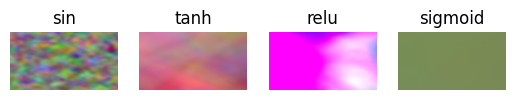

After 100 steps:
sin loss = 0.009293
tanh loss = 0.060302
relu loss = 0.116799
sigmoid loss = 0.097636


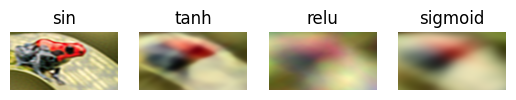

After 200 steps:
sin loss = 0.004755
tanh loss = 0.048556
relu loss = 0.094614
sigmoid loss = 0.083597


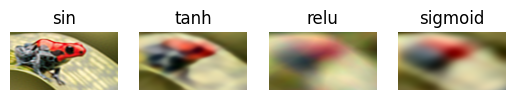

After 300 steps:
sin loss = 0.002629
tanh loss = 0.038188
relu loss = 0.086709
sigmoid loss = 0.073905


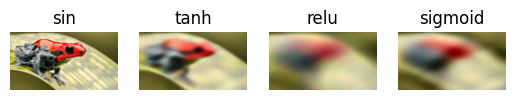

After 400 steps:
sin loss = 0.001574
tanh loss = 0.033338
relu loss = 0.081247
sigmoid loss = 0.068041


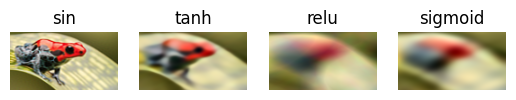

After 500 steps:
sin loss = 0.000994
tanh loss = 0.030414
relu loss = 0.076831
sigmoid loss = 0.064726


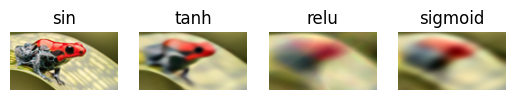

After 600 steps:
sin loss = 0.000633
tanh loss = 0.027866
relu loss = 0.072942
sigmoid loss = 0.062290


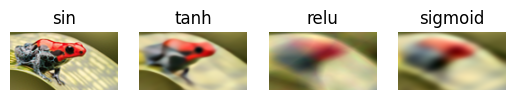

After 700 steps:
sin loss = 0.000411
tanh loss = 0.025565
relu loss = 0.069205
sigmoid loss = 0.068233


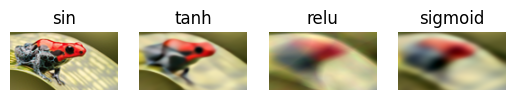

After 800 steps:
sin loss = 0.000272
tanh loss = 0.029159
relu loss = 0.065803
sigmoid loss = 0.058072


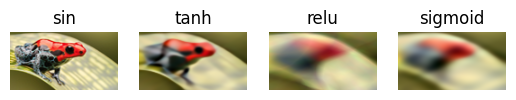

After 900 steps:
sin loss = 0.000183
tanh loss = 0.022137
relu loss = 0.062920
sigmoid loss = 0.056409


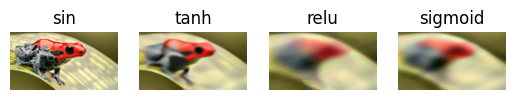

After 1000 steps:
sin loss = 0.000129
tanh loss = 0.021026
relu loss = 0.066469
sigmoid loss = 0.054386


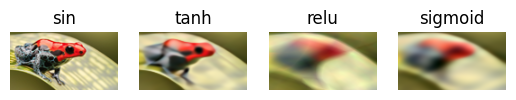

In [7]:
#@title Finally, we train the siren to fit the image.

# Implement the training loop.

run_comparison_training_loop( my_models, my_optims, my_dataloader, 1000, 100 )

In [8]:
#@title Saving/loading the models

i_want_to = 'load'

if i_want_to == 'save':
    for m in my_models:
        torch.save(m.cpu().state_dict(), '/content/drive/MyDrive/training/frog/fcff-%s' % m.func.__name__)
        if torch.cuda.is_available():
            m.cuda()

elif i_want_to == 'load':
    for m in my_models:
        m.load_state_dict(torch.load('/content/drive/MyDrive/training/frog/fcff-%s' % m.func.__name__))
        if torch.cuda.is_available():
           m.cuda()

# Visualising the flow of information along a network

This is the output of neurons in the layers of the sin network


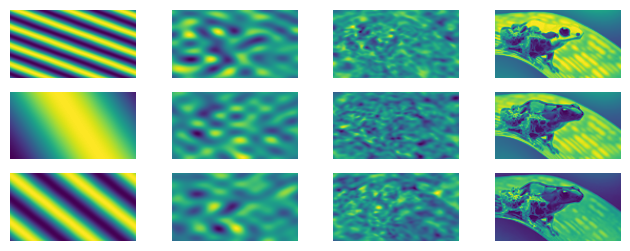

This is the output of neurons in the layers of the tanh network


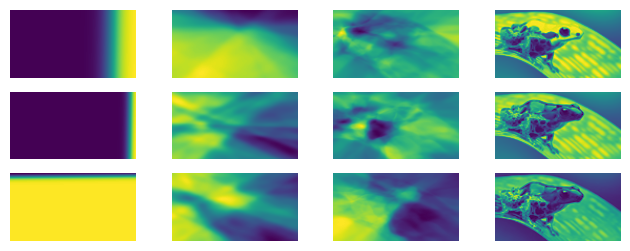

This is the output of neurons in the layers of the relu network


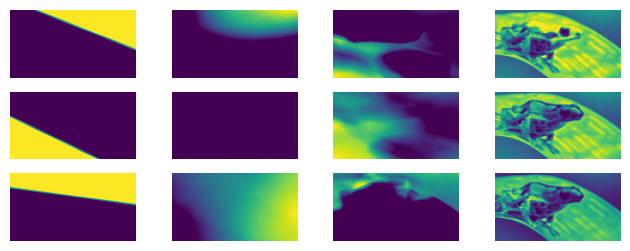

This is the output of neurons in the layers of the sigmoid network


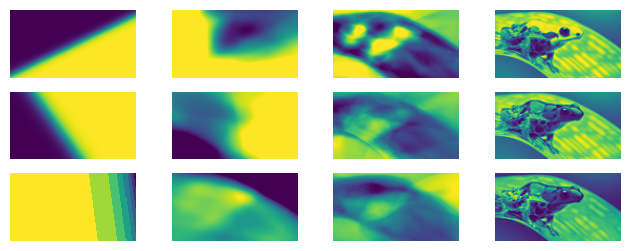

In [9]:
#@title Showing the output of the neurons

def display_neuron_output(model):

    p_list = [ p for p in model.parameters() ]

    model_input, _ = next(iter(my_image_fitter))

    img_list = []

    for i in range(no_of_hidden+1):
        img_list_j = []

        for j in range(no_of_channels):
            layer_sizes = [2] + [size_of_hidden for k in range(i)] + [1]

            if i == 0:
                outmost_lin = False
            else:
                outmost_lin = True

            new_model = FCFFNetwork(model.func, layer_sizes, outermost_linear=outmost_lin)

            new_state = OrderedDict({})
            for k in range(i):
                new_state['net.%d.linear.weight' % k] = p_list[2*k]
                new_state['net.%d.linear.bias' % k] = p_list[2*k+1]

            if i == 0:
                new_state['net.%d.linear.weight' % i] = p_list[2*i][j].unsqueeze(0)
                new_state['net.%d.linear.bias' % i] = p_list[2*i+1][j].unsqueeze(0)
            else:
                new_state['net.%d.weight' % i] = p_list[2*i][j].unsqueeze(0)
                new_state['net.%d.bias' % i] = p_list[2*i+1][j].unsqueeze(0)

            new_model.load_state_dict(new_state)

            model_output, coords = new_model(model_input)

            t = (model_output + 1)/2
            t = torch.max( torch.zeros_like(t), torch.min( torch.ones_like(t), t ) )
            a = t.cpu().view(img_height, img_width).detach().numpy()
            img_list_j.append(a)

        img_list.append(img_list_j)

    fig,ax = plt.subplots(no_of_channels, no_of_hidden+1, figsize = ((no_of_hidden+1)*2, 3))

    for i in range(no_of_channels):
        for j in range(no_of_hidden+1):
            if no_of_channels == 1:
                ax[j].imshow(img_list[j][i])
                ax[j].axis('off')
            else:
                ax[i,j].imshow(img_list[j][i])
                ax[i,j].axis('off')

    plt.show()

for m in my_models:
    print('This is the output of neurons in the layers of the %s network' % m.func.__name__)
    display_neuron_output(m)

# Perturbing the parameters in each layer

In [10]:
#@title Perturbing

def my_tensor_like(t):
    t_length = t.flatten().shape[0]
    i = random.randint(0, t_length - 1)
    with_random_1 = torch.zeros_like(t.flatten())
    with_random_1[i] = 1
    with_random_1 = with_random_1.reshape(t.shape)
    return with_random_1

img_list = []

#eps = [1, pi/15, 1, pi/15, 1, pi/15, 1, 1]
eps = [0.01, 0.01, 0.001, 0.01, 0.002, 0.02, 0.1, 1]

zm = [ [2,-2], [1.1, 0.9], [1.5, -1.5], [1.5, 0.5], [1.5, -1.5], [2, 0], [2, -2], [11, -9]]

def perturb_ith_parameter( model, i, scale_factor=1, nudge_factor=0.1 ):

    model_sd = model.state_dict()
    param_keys = list(model_sd.keys())
    param_key = param_keys[i]
    random_tensor = torch.randn_like(model_sd[param_key])
    model_sd[param_key] = scale_factor * model_sd[param_key] + nudge_factor * random_tensor

def perturb_parameters( model ):

    no_of_params = len(list(model.parameters()))

    for i in range(no_of_params):

        new_model = type(model)(model.func, model.layer_sizes)

        new_model.load_state_dict(model.state_dict())
        #new_model = new_model.cuda()

        #perturb_ith_parameter( new_model, i, scale_factor=1.5 )

        model_sd = new_model.state_dict()
        param_keys = list(model_sd.keys())
        param_key = param_keys[i]
        orig_value = model_sd[param_key].clone()
        #random_tensor = torch.randn_like(orig_value)
        random_tensor = my_tensor_like(orig_value)

        img_i_list = []

        for j in range(51):

            model_sd[param_key] = (j/25-1)*orig_value + (j-25)*random_tensor
            #model_sd[param_key] = (j/10-1)*orig_value

            new_model.load_state_dict(model_sd)

            model_input, ground_truth = next(iter(my_dataloader))
            #model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

            model_output, coords = new_model(model_input)

            t = (model_output + 1)/2
            t = torch.max( torch.zeros_like(t), torch.min( torch.ones_like(t), t ) )
            a = t.cpu().permute(1,2,0).view(img_height, img_width, no_of_channels).detach().numpy()
            img_i_list.append(a)
        img_list.append(img_i_list)




In [ ]:
#@title Make gifs

def make_gif(frames,path):
    frame_one = frames[0]
    frame_one.save(path, format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0, optimise=True)

top_pad = 15
left_pad = 15
pad = 5
pad_width = img_width + 2*pad
pad_height = img_height + 2*pad


no_of_params = 8
no_of_models = len(my_models)

total_width = pad_width * no_of_params + left_pad
total_height = pad_height * no_of_models + top_pad


img_list = []

for m in my_models:
    perturb_parameters( m )

comp_list = []

for k in range(len(img_list[0])):
    new_im = Image.new('RGB', (total_width, total_height), color='white')
    draw = ImageDraw.Draw(new_im)
    for i in range(no_of_params):
        for j in range(no_of_models):
            x = img_list[i+no_of_params*j][k]
            if no_of_channels == 1:
                x = np.squeeze(x, axis=2)
            new_im.paste(Image.fromarray((x * 255).astype(np.uint8)), (i*pad_width + left_pad, j*pad_height + top_pad))
        if (i - 2*(i//2)) == 0:
            draw.text( (i*pad_width + left_pad, 0), 'Weight %d' % (i//2), 'black')
        else:
            draw.text( (i*pad_width + left_pad, 0), 'Bias %d' % (i//2), 'black')

    txt=Image.new('RGB', (total_height, left_pad), color='white')

    d = ImageDraw.Draw(txt)

    for i in range(no_of_models):
        d.text( (i*pad_height + 2*pad, 0), my_models[no_of_models-i-1].func.__name__, 'black')

    w = txt.rotate(90,  expand=1)

    new_im.paste( w, (0,0) )

    comp_list.append(new_im)





comp_list_rev = comp_list.copy()
comp_list_rev.reverse()

make_gif( comp_list + comp_list_rev, "/content/drive/MyDrive/eyes/gif/uu")

from IPython.display import Image as Image2

Image2(open("/content/drive/MyDrive/eyes/gif/uu",'rb').read())




# Playing with the biases

In [ ]:
#@title With no bias

new_network = FCFFNetwork( torch.cos, layer_sizes, first_bias=False, hidden_bias=False, last_bias=False)

if torch.cuda.is_available():
    new_network.cuda()

new_siren_optimiser = torch.optim.Adam(lr=1e-4, params=new_network.parameters())

run_training_loop(new_network, new_siren_optimiser, my_dataloader, 6000, 1000)